In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Flatten, Dropout, LSTM, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from tensorflow.keras.regularizers import l1_l2

In [2]:
file_path = pd.read_csv('D:\\4TH YEAR\\FYP\\taasha\\real_BABY.csv')

In [3]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    return validate_data(data)

In [4]:
def validate_data(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]

    if 'Timestamp' in df.columns:
        df = df.sort_values('Timestamp')

    return df

In [5]:
input_features = ['Timestamp', 'volData', 'currentData']
output_features = ['batTempData', 'socData', 'sohData', 'motTempData', 'speedData']

In [6]:
def create_sequences(X, y, lookback=5, stride=1):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - lookback, stride):
        sequence_x = X[i:(i + lookback)]
        target_y = y[i + lookback]
        X_seq.append(sequence_x)
        y_seq.append(target_y)
    return np.array(X_seq), np.array(y_seq)

In [7]:
def build_enhanced_model(input_shape, output_dim):
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, LSTM, Flatten, Add
    from tensorflow.keras.regularizers import l1_l2

    # Regularization parameters
    l1_reg = 1e-5
    l2_reg = 1e-4

    # Input layer
    inputs = Input(shape=input_shape)

    # LSTM branch with regularization
    lstm = LSTM(256, return_sequences=True, activation='tanh', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(inputs)
    lstm = Dropout(0.3)(lstm)
    lstm = LSTM(128, return_sequences=True, activation='tanh', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(lstm)
    lstm = Dropout(0.3)(lstm)
    lstm = LSTM(64, return_sequences=False, activation='tanh', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(lstm)

    # Dense branch with regularization
    dense = Flatten()(inputs)
    dense = Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.4)(dense)
    dense = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.3)(dense)

    # Merge branches
    merged = Add()([
        Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(lstm),
        Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(dense)
    ])
    merged = BatchNormalization()(merged)
    merged = Dropout(0.3)(merged)

    # Fully connected layers with regularization
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    # Output layer for multi-output regression
    outputs = Dense(output_dim, activation='linear', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [8]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model, epochs=200):
    callbacks = [EarlyStopping(monitor='val_loss',patience=30,restore_best_weights=True,verbose=1),
        ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10,min_lr=1e-6,verbose=1)]
    # Train model
    history = model.fit(X_train, y_train,epochs=epochs,batch_size=32,validation_split=0.2,callbacks=callbacks,verbose=1)
    return history, model

In [9]:
def plot_predictions(y_true, y_pred, feature_name, metrics):
    plt.figure(figsize=(15, 7))

    sample_size = min(200, len(y_true))

    time_index = np.arange(sample_size)

    plt.plot(time_index, y_true[:sample_size], 'b-', label='True', linewidth=2)
    plt.plot(time_index, y_pred[:sample_size], 'r--', label='Predicted', linewidth=2)

    plt.title(f'{feature_name} - True vs Predicted Values', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.text(0.02, 0.98,
             f'Accuracy: {metrics["accuracy"]:.2f}%',
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()


Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 0.9134 - val_loss: 0.4159 - learning_rate: 0.0010
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.5685 - val_loss: 0.4040 - learning_rate: 0.0010
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.4791 - val_loss: 0.3987 - learning_rate: 0.0010
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.4335 - val_loss: 0.3940 - learning_rate: 0.0010
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4073 - val_loss: 0.3867 - learning_rate: 0.0010
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3930 - val_loss: 0.3907 - learning_rate: 0.0010
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3871 - val_loss: 0.3787 - learning_rate: 0.0010
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3804 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3698 - val_loss: 0.3713 - learning_rate: 0.0010
Epoch 10/

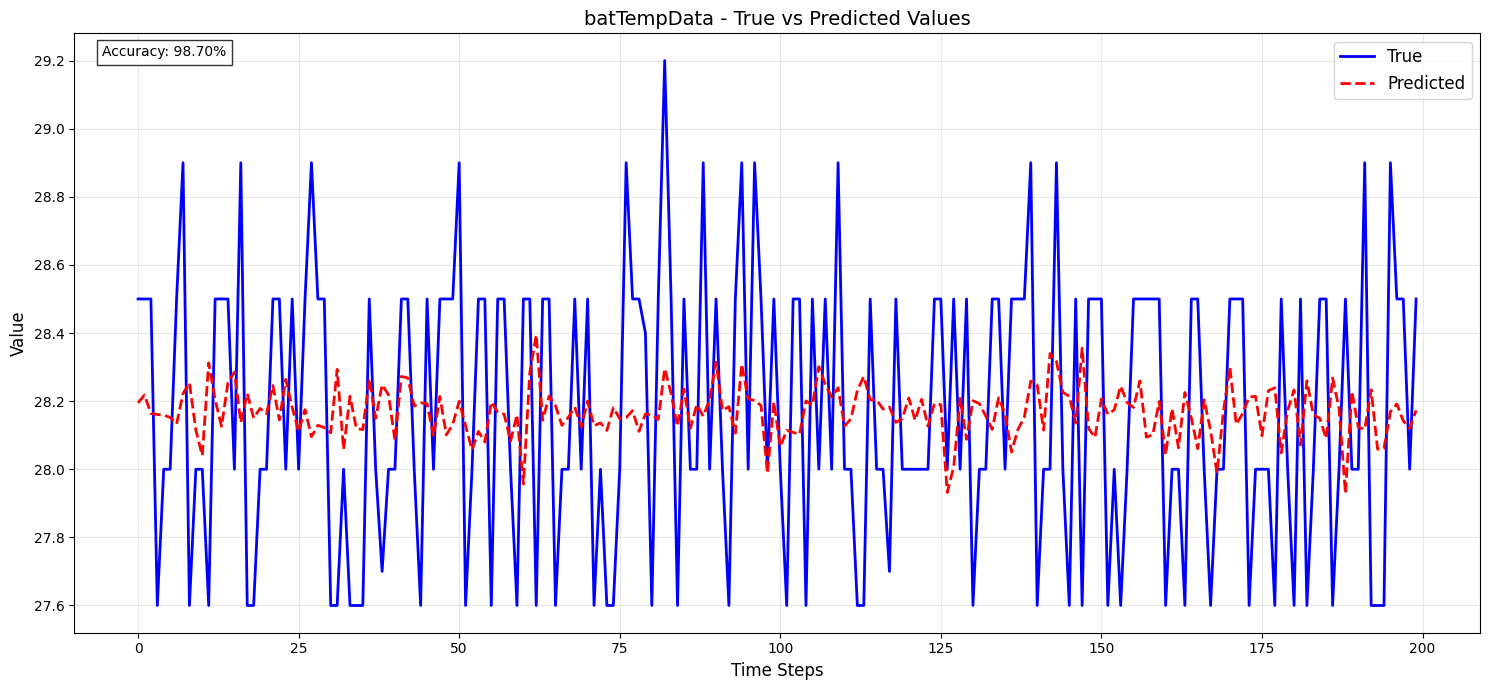


batTempData:
Accuracy: 98.70%


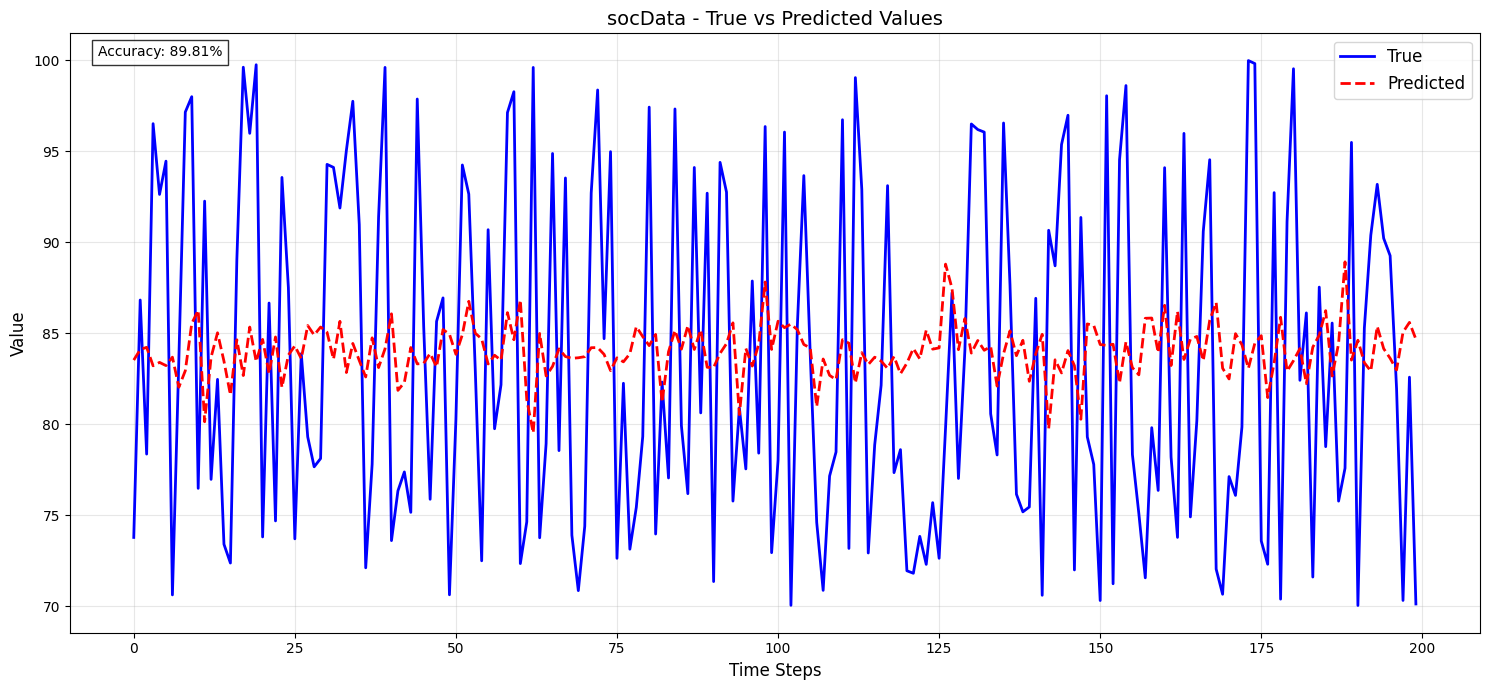


socData:
Accuracy: 89.81%


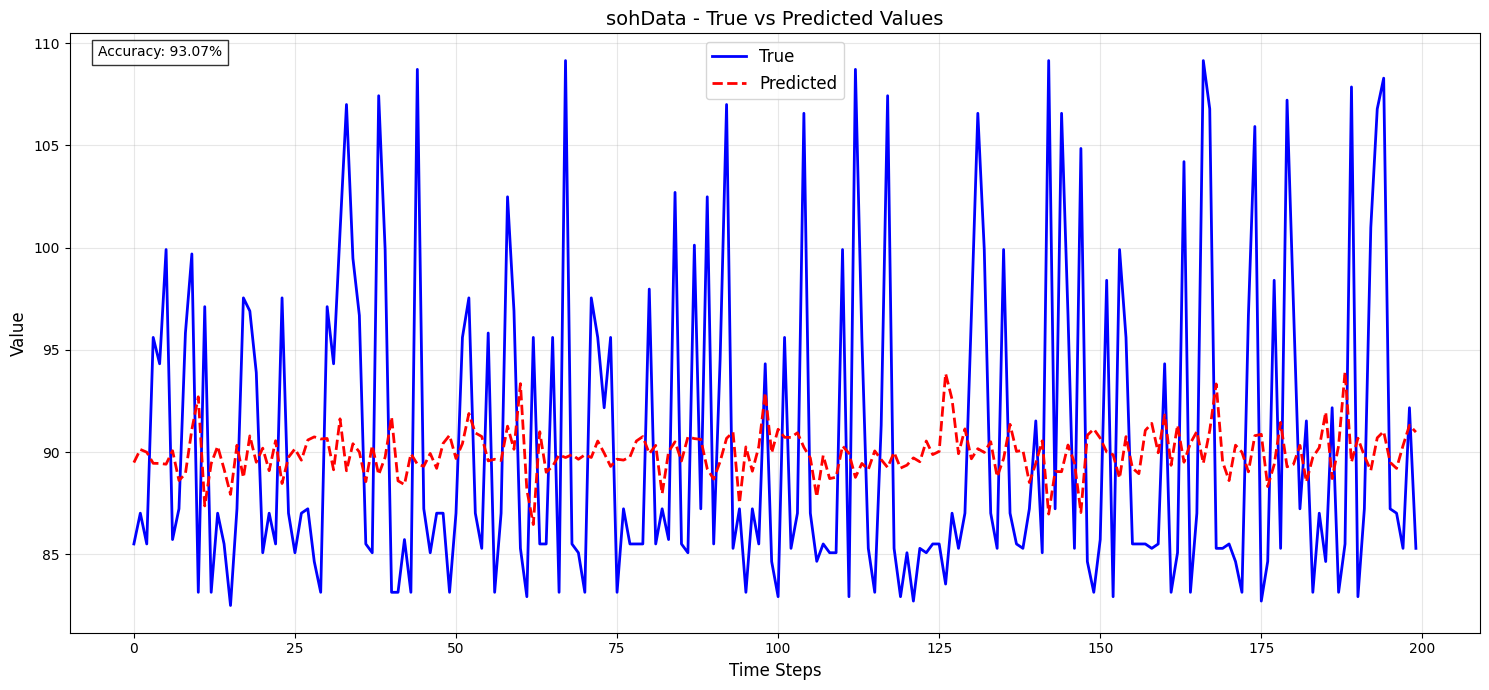


sohData:
Accuracy: 93.07%


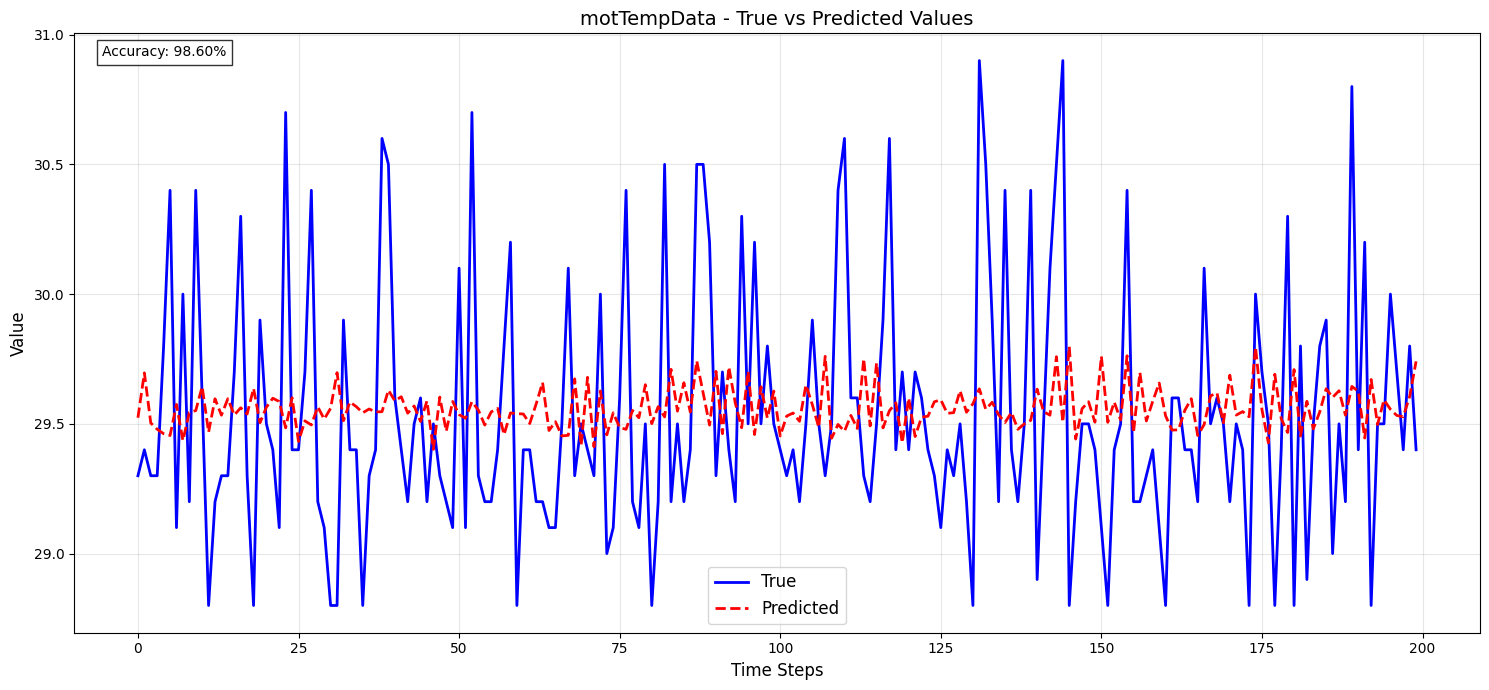


motTempData:
Accuracy: 98.60%


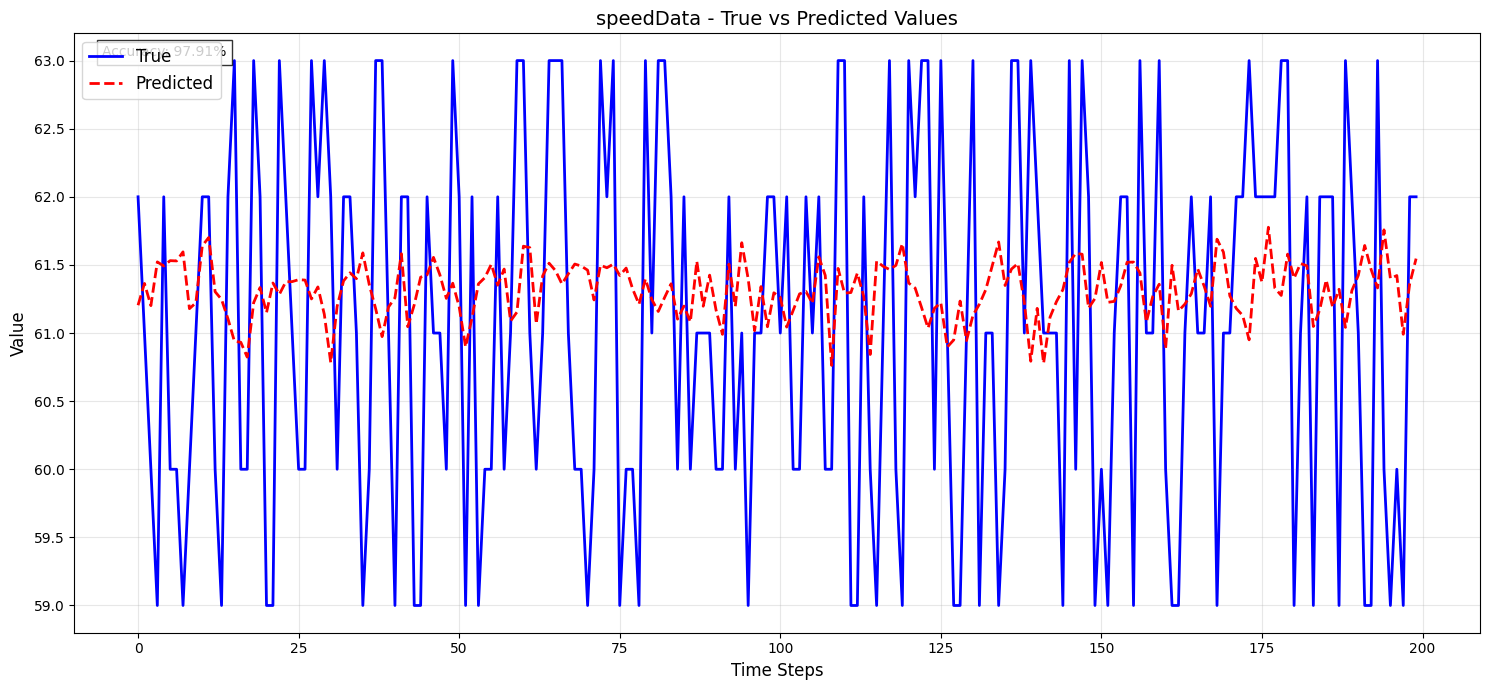


speedData:
Accuracy: 97.91%

Overall Average Accuracy: 95.62%


In [10]:
if __name__ == "__main__":
    input_features = ['Timestamp', 'volData', 'currentData']
    output_features = ['batTempData', 'socData', 'sohData', 'motTempData', 'speedData']
    lookback = 10 
    stride = 2    

    data = load_and_preprocess_data('randsam_BABY.csv')

    scalers_x = {feature: RobustScaler() for feature in input_features}
    scalers_y = {feature: RobustScaler() for feature in output_features}

    X_scaled = np.column_stack([
        scalers_x[feature].fit_transform(data[feature].values.reshape(-1, 1))
        for feature in input_features
    ])

    y_scaled = np.column_stack([
        scalers_y[feature].fit_transform(data[feature].values.reshape(-1, 1))
        for feature in output_features
    ])

    X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback, stride)

    split_idx = int(len(X_seq) * 0.8)
    X_train = X_seq[:split_idx]
    X_test = X_seq[split_idx:]
    y_train = y_seq[:split_idx]
    y_test = y_seq[split_idx:]

    input_shape = (lookback, len(input_features))
    output_dim = len(output_features)
    model = build_enhanced_model(input_shape, output_dim)

    model.compile(optimizer=Adam(learning_rate=0.001),loss='huber' )


    history, model = train_and_evaluate_model(X_train, y_train, X_test, y_test, model)

    y_pred = model.predict(X_test)

    overall_accuracy = 0
    for i, feature in enumerate(output_features):
        # Inverse transform predictions
        y_test_original = scalers_y[feature].inverse_transform(y_test[:, i].reshape(-1, 1)).ravel()
        y_pred_original = scalers_y[feature].inverse_transform(y_pred[:, i].reshape(-1, 1)).ravel()

        metrics = {'accuracy': 100 - mean_absolute_percentage_error(y_test_original, y_pred_original) * 100}
        overall_accuracy += metrics['accuracy']

        plot_predictions(y_test_original, y_pred_original, feature, metrics)

        print(f"\n{feature}:")
        print(f"Accuracy: {metrics['accuracy']:.2f}%")

    print(f"\nOverall Average Accuracy: {overall_accuracy/len(output_features):.2f}%")


    model.save('NARX_nn_rial.h5')
    model.save_weights('NARX_model_rial.weights.h5')

In [11]:
def predict_custom_input(custom_input, model, scalers_x, scalers_y, lookback, input_features, output_features):
    if len(custom_input) != len(input_features):
        raise ValueError(f"Expected {len(input_features)} features, but got {len(custom_input)}.")

    # Scale each feature individually using the corresponding scaler
    scaled_values = []
    for value, feature in zip(custom_input, input_features):
        scaled_value = scalers_x[feature].transform([[value]])
        scaled_values.append(scaled_value.ravel())

    # Combine scaled values
    custom_input_scaled = np.column_stack(scaled_values)

    # Create sequence with lookback
    input_sequence = np.zeros((1, lookback, len(input_features)))
    input_sequence[0, :] = np.repeat(custom_input_scaled.reshape(1, -1), lookback, axis=0)

    # Predict
    pred_scaled = model.predict(input_sequence, verbose=0)

    # Inverse transform each output feature
    predictions = []
    for i, feature in enumerate(output_features):
        pred_value = scalers_y[feature].inverse_transform(
            pred_scaled[:, i].reshape(-1, 1)
        ).ravel()
        predictions.append(pred_value)

    return np.column_stack(predictions)

In [12]:
if __name__ == "__main__":
    print("\nTesting custom prediction functionality:")
    sample_input = [0, 3.85, 0.2900]  

    try:
        predicted_output = predict_custom_input(sample_input,model,scalers_x,scalers_y,lookback,input_features,output_features)
        print("\nCustom Input Prediction:")
        print("Input values:", dict(zip(input_features, sample_input)))
        print("\nPredicted outputs:")
        for i, feature in enumerate(output_features):
            print(f"{feature}: {predicted_output[0][i]:.4f}")

    except Exception as e:
        print(f"Error during prediction: {str(e)}")


Testing custom prediction functionality:

Custom Input Prediction:
Input values: {'Timestamp': 0, 'volData': 3.85, 'currentData': 0.29}

Predicted outputs:
batTempData: 28.0462
socData: 85.3223
sohData: 90.4205
motTempData: 29.4062
speedData: 61.2383


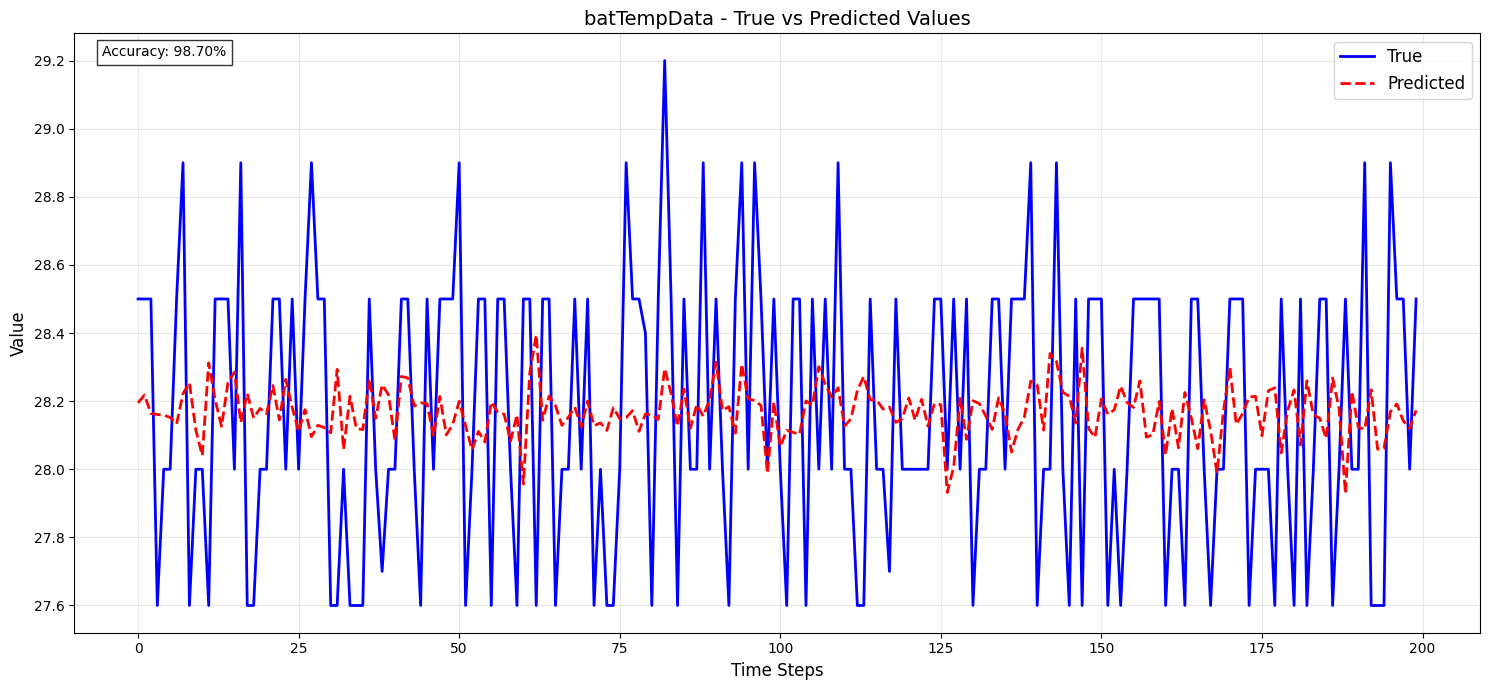


Metrics for batTempData:
Accuracy: 98.70%
R² Score: -0.0287


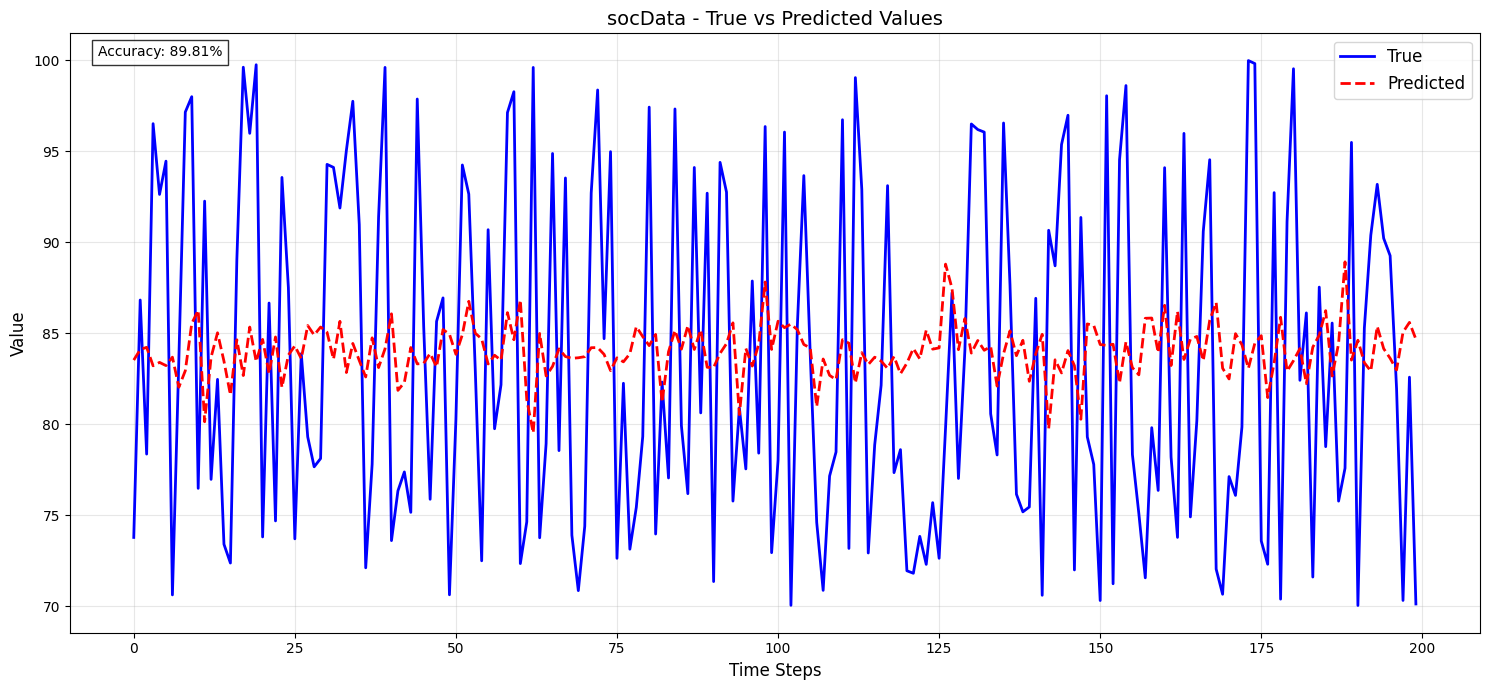


Metrics for socData:
Accuracy: 89.81%
R² Score: -0.0136


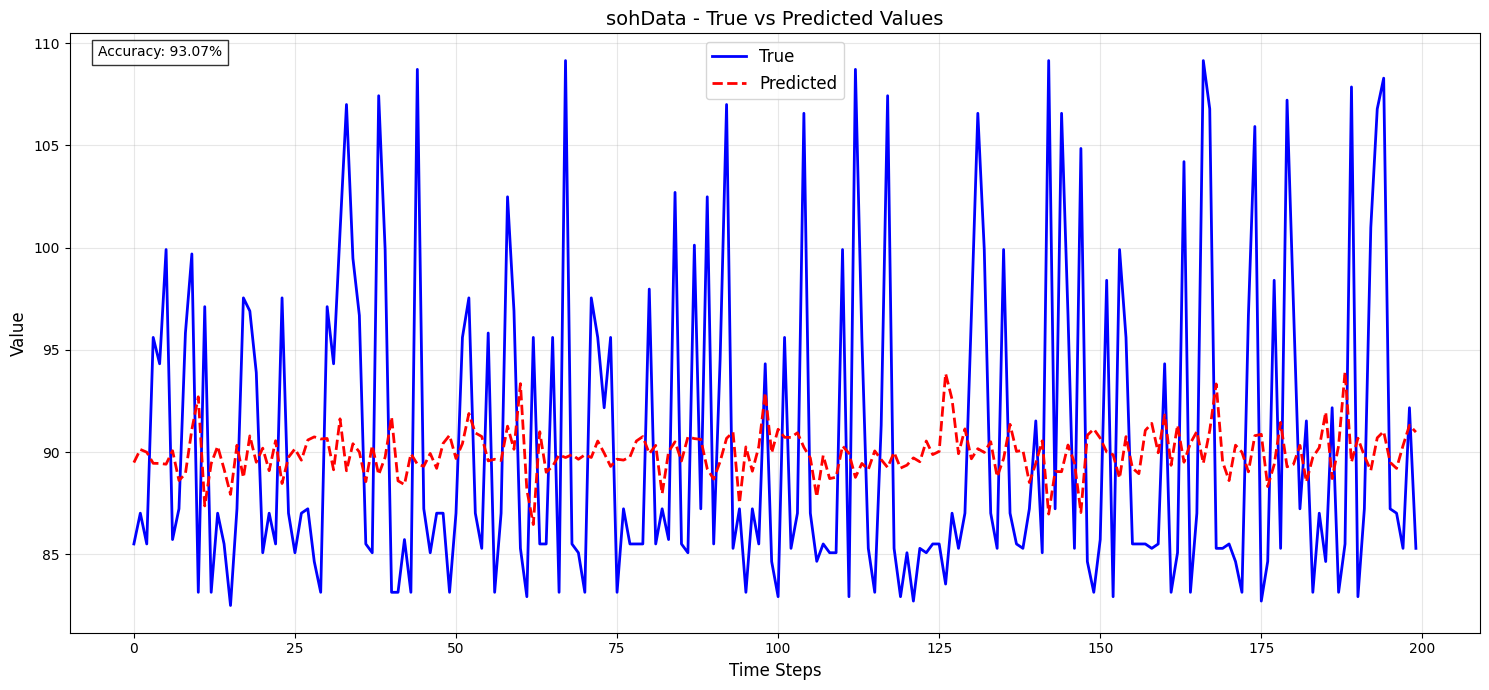


Metrics for sohData:
Accuracy: 93.07%
R² Score: -0.0192


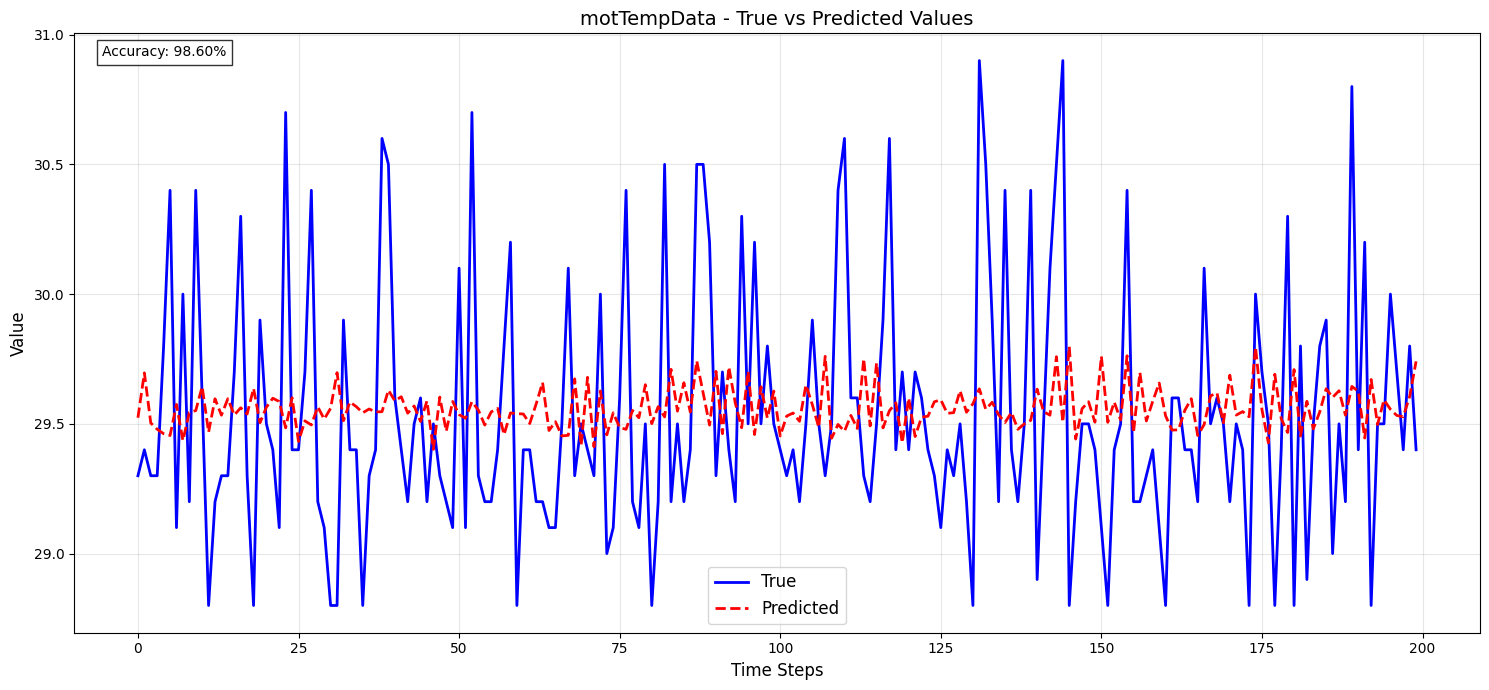


Metrics for motTempData:
Accuracy: 98.60%
R² Score: -0.0291


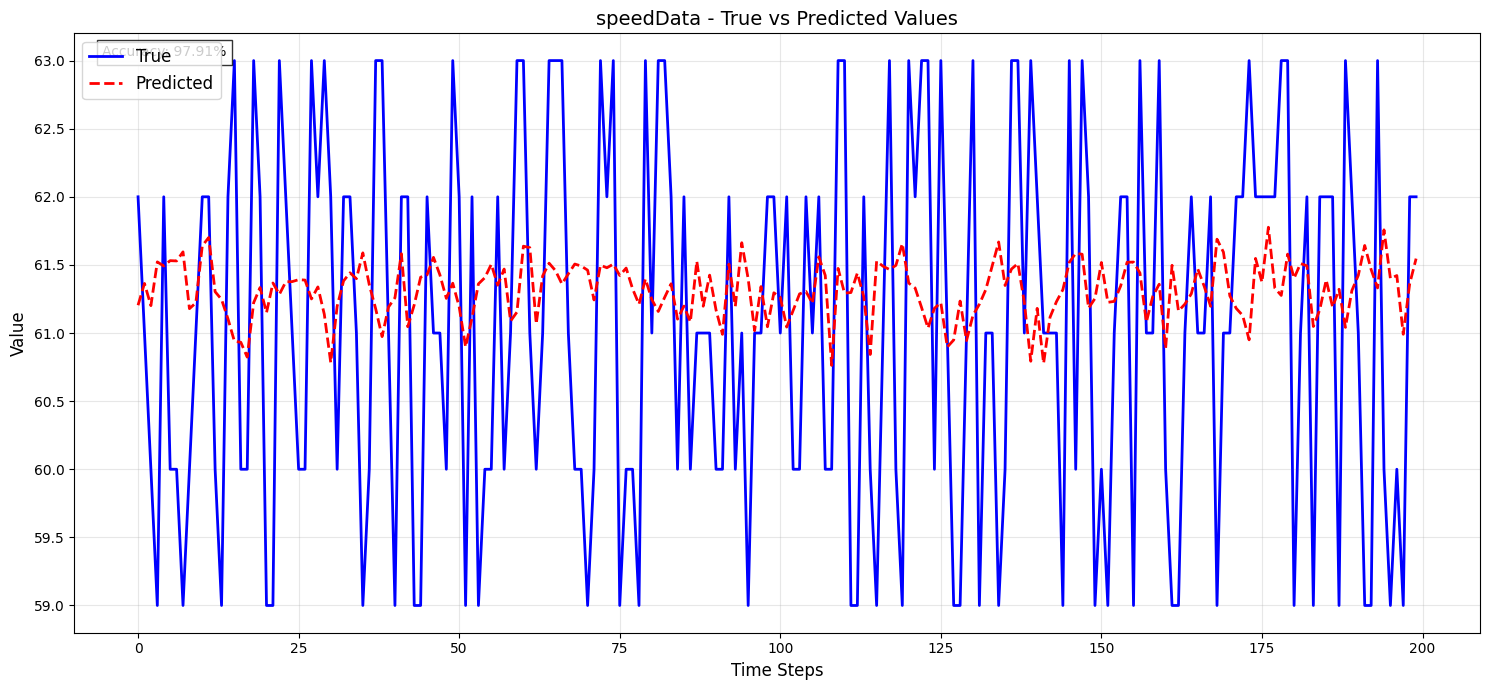


Metrics for speedData:
Accuracy: 97.91%
R² Score: -0.0588

Overall Model Performance:
Overall Accuracy: 95.62%
Overall R² Score: -0.0299


In [13]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

overall_accuracy = 0
overall_r2 = 0

for i, feature in enumerate(output_features):
    # Inverse transform predictions
    y_test_original = scalers_y[feature].inverse_transform(y_test[:, i].reshape(-1, 1)).ravel()
    y_pred_original = scalers_y[feature].inverse_transform(y_pred[:, i].reshape(-1, 1)).ravel()

    # Calculate metrics
    accuracy = 100 - mean_absolute_percentage_error(y_test_original, y_pred_original) * 100
    r2 = r2_score(y_test_original, y_pred_original)

    # Accumulate metrics
    overall_accuracy += accuracy
    overall_r2 += r2

    # Plot results
    plot_predictions(y_test_original, y_pred_original, feature, {'accuracy': accuracy, 'r2': r2})

    # Print feature-wise metrics
    print(f"\nMetrics for {feature}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"R² Score: {r2:.4f}")

# Calculate and print overall metrics
overall_accuracy /= len(output_features)
overall_r2 /= len(output_features)

print(f"\nOverall Model Performance:")
print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(f"Overall R² Score: {overall_r2:.4f}")
